In [1]:
%matplotlib inline
import cv2
import numpy as np
import os, os.path
from scipy.cluster.vq import vq, kmeans
from scipy.spatial import distance, distance_matrix
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import plot_confusion_matrix
import random

### Q1. A) HSV k-means model, where k = 64 

In [2]:
# https://stackoverflow.com/questions/26392336/importing-images-from-a-directory-python-to-list-or-dictionary
# https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder/47114735

# A function to get 1500 images (100 from first 15 classes) from database, 
# convert them to HSV, and store their labels

def get_HSV_images_and_labels():
    images = []
    index = []
    count = 0
    path = "C:\Users\Shelby\Desktop\UMKC\Academics\Fall20\ComputerVision\NWPU-RESISC45"
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for filename in os.listdir(folder_path):
            if count < 100:
                img = cv2.imread(os.path.join(folder_path, filename))
                if img is not None:
                    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                    images.append(hsv_img) 
                    index.append(folder)
                    count += 1
            else:
                len(images)
                count = 0
                break
                
    return images, index

In [3]:
images, index = get_HSV_images_and_labels()

In [4]:
# A function to get the color codebook, i.e. hsv_table,
# which is a quantization of the colors in the 1500 images

def get_color_codebook(images):
    # flatten images to h*w by 3
    flattened_images = []
    for image in images:
        flattened_images.append(image.reshape(-1, 3))
    
    # get random pixels to get sample colors to train codebook
    hsv_train = []
    for image in flattened_images:
        sample = shuffle(image, random_state=0)[:100] # shuffle image matrix, then return first 100 pixels
        for pixel in sample:
            hsv_train.append(pixel.astype(np.float))
    
    # create color_codebook of 64 colors
    hsv_table, _ = kmeans(hsv_train, 64)
    
    return hsv_table

In [5]:
color_codebook = get_color_codebook(images)

### Q1. B) Histogram for each image

In [6]:
# https://stackoverflow.com/questions/43650931/python-alternative-for-calculating-pairwise-distance-between-two-sets-of-2d-poin
# https://www.tutorialspoint.com/scipy/scipy_cluster.htm
# https://giusedroid.blogspot.com/2015/04/using-python-and-k-means-in-hsv-color.html
# https://docs.scipy.org/doc/scipy/reference/cluster.vq.html

# A function that gets the histogram for a single image.
# There are 64 bins. If print_histo = True, function will
# display the image's histogram. If print_scatter = True, function
# will print a scatterplot of the HSV values of the color codebook.

def getHist(im, color_bins, print_histo = False, print_scatter = False):
    cluster_data = im.reshape(-1, 3)
    [n, dim] = cluster_data.shape 
    [m, dim] = color_bins.shape
    
    # vq: assigns codes from a codebook to obervations.
    # Quantizes image; assigns each value into one of the predetermined color bins (clusters)
    data, _ = vq(cluster_data[:,0:3], color_bins)
    
    # calculates the number of elements for each cluster
    weights = [len(data[data == i]) for i in range(0,64)]

    # squeezes values between 0 and 1 so sum of histogram (the returned vector) = 1
    normalized_weights = []
    for weight in weights:
        normalized_weights.append(float(weight)/sum(weights))
    
    if (print_scatter):
        fig = plt.figure()
        ax = plt.axes(projection="3d") # scatterplot for color codebook
        ax.scatter3D(color_bins[:, 0], color_bins[:, 1], color_bins[:, 2])
        ax.set_xlabel('Hue')
        ax.set_ylabel('Saturation')
        ax.set_zlabel('Value')
        
    if (print_histo):
        fig = plt.figure()    
        plt.bar(np.arange(len(normalized_weights)), normalized_weights) # histogram for image
 
    return normalized_weights

### Q1. C) Use Euclidean distance to measure similarity between two images

0.5862031008832774

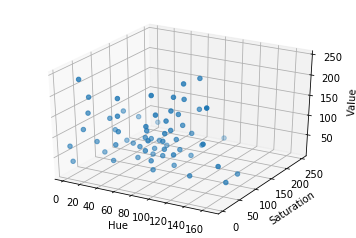

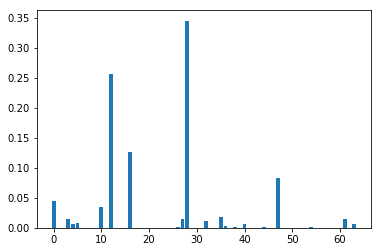

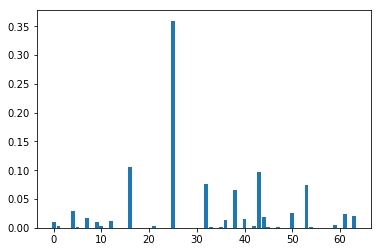

In [7]:
# A function that uses the Euclidean distance to measure the simliarity between two images.
# The following line selects two random images from the dataset to compare.
# This code block can be run multiple times to compare two random images.
# Notice how the Euclidean distance and histograms change each time, but the
# scatterplot stays the same to reflect unchanging values in color codebook.

def get_HSV_dist(im1, im2, color_table):
    hist1 = np.asarray(getHist(im1, color_table, True, True))
    hist2 = np.asarray(getHist(im2, color_table, True))
    return distance.euclidean(hist1, hist2)

get_HSV_dist(images[random.randint(0, 399)], images[random.randint(0, 399)], color_codebook)

### Q1. D) 1-NN of 400 random images from dataset

In [8]:
# A utility function that converts a list of HSV images into histograms

def convertListToHists(im_list, color_table):
    imageHists = []
    for image in im_list:
        imageHists.append(getHist(image, color_table))
    return imageHists

In [9]:
# https://towardsdatascience.com/k-nearest-neighbor-python-2fccc47d2a55
# https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/

# Gets the test and train data for a knn classifier model 
# using HSV image as data and their corresponding class labels.
# images: A list of HSV images.
# index:  A list of corresponding labels for the images.

data, labels = shuffle(images, index, random_state=0)
data_test = data[:400]
data_train = data[400:] # size = 1100
labels_test = labels[:400]
labels_train = labels[400:] # size = 1100

data_train = convertListToHists(data_train, color_codebook)
data_test = convertListToHists(data_test, color_codebook)

In [10]:
knn = KNeighborsClassifier(n_neighbors=1, metric="euclidean").fit(np.array(data_train).reshape(1100,-1), labels_train)
prediction = knn.predict(data_test)
accuracy = knn.score(data_test, labels_test)
print(accuracy)

0.6


In [13]:
# unique_labels = list(set(labels_test)) # for stretch goal - fancier plotting
cm = confusion_matrix(labels_test, prediction)

In [12]:
print(cm)

[[14  0  0  0  3  0  0  0  2  0  4  0  0  0  0]
 [ 0 12  1  0  3  0  1  3  0  2  2  0  0  0  1]
 [ 1  0 15  2  3  2  2  3  0  1  1  2  1  0  0]
 [ 0  0  0 16  0  1  0  1  2  0  0  0  0  0  0]
 [ 3  0  0  0 19  0  2  3  0  1  1  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  1  0  1  0  0  0  0]
 [ 1  2  0  0  3  0 15  5  3  0  0  0  0  0  0]
 [ 1  3  0  0  1  1  2 13  1  1  1  0  0  0  0]
 [ 3  0  1  5  0  1  3  0  6  1  0  1  0  1  1]
 [ 0  0  0  0  0  0  5  1  0 26  0  0  0  0  0]
 [ 2  2  0  0  1  0  0  1  0  0 13  0  0  0  0]
 [ 2  0  0  0  1  4  1  0  0  0  2 20  0  1  2]
 [ 0  0  2  4  1  0  0  0  0  0  3  0 18  0  4]
 [ 0  0  0  2  0  1  0  0  0  0  0  0  0 18  0]
 [ 1  0  0  1  5  1  4  1  1  1  0  1  4  0 10]]
